In [ ]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
from scipy.linalg import expm
from scipy.special import smirnov

sns.set_style("white")

# 02443 Stochastic Simulation - Project 1

Group number 4

16-06-2022


| Students                      | ID        |
| -------------                 |:---------:|
| Mie REDACTED                  | REDACTED  |
| Rasmus REDACTED               | REDACTED  |
| Benjamin Starostka Jakobsen   | s184198   |
| Muhammad REDACTED             | REDACTED  |
| Victor REDACTED               | REDACTED  |

# Introduction
In this project we want to simulate and analyse a Markov model of breast cancer. The aim is by using the model and different methods we are able to describe possible complications following a surgery for breast cancer. 

## Markov Chains
The Markov Chains model follows that the random variables $X_t$ for $t=0,1,\dots$ are indexed by time and can attain the values $1,2,\dots,N$. The random variables folloes the Markov property:

$P(X_{t+1}|X_1,X_2,...,X_t)=P(X_{t+1}|X_t)$

That meant that next value of $X_{t+1}$ can be determined of the value of $X_t$. The relationsship between $X_t$ and $X_{t+1}$ can be described with probabilities of going from state $i\in\{1,2,..,N \}$ to state $j\in\{1,2,..,N \}$. This is presented in a $NxN$ probapillity matrix $p_{ij}$. The matrix has the condition that $\sum_{j=1}^{N}p_{ij}=1, \forall i=1,2,...,N.$ 


# Part 1: A discrete-time model
In this part of the project, we will work with the above-presented Markov model. 

## Breast cancer assumptions
This study follows women after they had a breast tumor removed. Every woman can go through different stages:

* **State 1:** Healthy. The woman in this state stays healthy.
* **State 2:** Local Recurrence. Cancer reappears close to the removed tumor.
* **State 3:** Distant metastatis. Cancer reappears distant from where it was operated.
* **State 4:** Both Local Recurrence and Distant metastasis.
* **State 5:** Death. 

A woman cannot directly go from State 1 (Healthy) to state 4 (Both), the woman will reach first state 2 or state 3. Death can happen from any state. If the death state has been entered it can never be left again. The woman can also stay in the same state. 


## Task 1
In this task, we want to simulate 1000 women to investigate their lifetime distribution after surgery. All women start in state 1 and the simulation will run until the woman is dead (state 5). We will also investigate the proportion of women where cancer locally Recurrence.

Given $P$ a transition probability matrix $N\times N$.

$$
P=\begin{bmatrix} p_{11} & p_{12} & \cdots & p_{1N} \\ p_{21} & p_{22} & \cdots & p_{2N} \\ \vdots & \vdots & \ddots & \vdots \\ p_{N1} & p_{N2} & \cdots & p_{NN} \end{bmatrix}
$$

In this project we have $N=5$ states. This discrete Markov chain can be visualized below. The 5 states are represented as nodes and the transitions probabilities $p_{ij}$ as arrows between state $i$ and $j$. Notice how for each state the sum of all outgoing arrows is equal to 1.
![mc_sketch](Figures/sketch_markov_chain.png)

First, we want to program the expected distribution given a time $T$, for where the distribution should end. One time step is equal to one month. Then, the probability distribution over the states at time *t* follows the formula:

$$
\pi_t =\pi_{t-1}P \Leftrightarrow \pi_t = \pi_0P^{t}
$$  

The given probability matrix P and the program for expected distribution given a time $T$ are presented below.

In [ ]:
# Given probability matrix
P = [
    [0.9915, 0.005, 0.0025, 0, 0.001],
    [0, 0.986, 0.005, 0.004, 0.005],
    [0, 0, 0.992, 0.003, 0.005],
    [0, 0, 0, 0.991, 0.009],
    [0, 0, 0, 0, 1],
]
P = np.array(P)
N = P.shape[0]

In [ ]:
# ----- Expected distribution -----


def breast_cancer_analytical(T):
    timesteps = np.arange(0, T + 1)
    PIs = np.zeros((T + 1, N))
    PIs[0, :] = np.array([1, 0, 0, 0, 0])  # initial state distribution
    for t in timesteps[1:]:
        PIs[t, :] = PIs[t - 1, :] @ P

    return PIs

Next, we will program a stochastic simulation given $n$ women and a maximum time limit period $T_{max}$. $T_{max}$ is given to ensure that the simulation does not run too long (because a woman could potentially live very very long). The simulation will also terminate if all women are dead. If $T_{max}$ is too short and some women are still alive, a warning message will be printed and encourage them to regive a more significant time limit. The aim of the program is for every time step $t$ and every state $i$, update for each woman their state according to transition probabilities of state $i$. If the women still are alive 

The program is follow following steps:

* **Step 1:** Initialization. All women are healthy.
* **Step 2:** For every time step $t$ 
    * **Step 2.1:** For every state $i$, update the state of each woman in state $i$ according to transition probabilities of state $i$. 
    * **Step 2.2:** Increase lifetime by one for women still alive.
    * **Step 2.3:** Update empirical state probability distribution.
    * **Step 2.3:** Check if all women are dead, if it is the case terminate the simulation.
* **Step 3:** Check if any women still alive given the $T_{max}$ then print message.

Below is the program presented.

In [ ]:
# ----- Stochastic Simulation -----


def breast_cancer_simulation(P, n, Tmax, verbose=False):
    N = P.shape[0]
    T = Tmax

    # Initialization
    timesteps = np.arange(0, T + 1)
    pis = np.zeros((T + 1, N))
    lifetimes = np.zeros((n,))
    women = np.ones((T + 1, n), dtype=int)  # Initially, all women are healthy
    pis[0, :] = np.array([1, 0, 0, 0, 0])  # Initially, all women are healthy

    # Simulation loop
    for t in timesteps[1:]:
        # Batch update:
        # For each women in state i, update their state according to transition probabilities of state i.
        for i in range(N):
            transition_prob = P[i, :]
            state_i_idx = np.argwhere(women[t - 1, :] == i + 1).flatten()
            women[t, state_i_idx] = np.random.choice(
                np.arange(1, N + 1), p=transition_prob, size=len(state_i_idx)
            )

        # Increase lifetime by one for women still alive
        alive_idx = np.argwhere(women[t, :] < 5).flatten()
        lifetimes[alive_idx] += 1

        # Update empirical state probability distribution
        pis[t, :] = (
            np.array([len(np.argwhere(women[t, :] == i + 1)) for i in range(N)]) / n
        )

        if len(alive_idx) == 0:  # All women dead
            T = t
            break

    if len(alive_idx) != 0 and verbose:  # not all women dead
        print(
            "The simulation ended after %d months, not all women died in the period. To ensure that choose a significant Tmax"
            % T
        )

    return women[: T + 1, :], lifetimes, pis[: T + 1, :], T

In [ ]:
n = 1000  # number of women to simulate
women, lifetimes, PIs_sim, T = breast_cancer_simulation(P, n, Tmax=2000, verbose=True)
print(
    "Simulation ended, i.e. all women died, after {} months ({:.2f} years).".format(
        T, T / 12
    )
)
timesteps = np.arange(0, T + 1)

Simulation ended, i.e. all women died, after 1176 months (98.00 years).


The simulation terminates due to all women are dead. If we investigate time, we observe that it is unrealistic that a woman lives more than 100 years after breast cancer surgery. This model is not realistic for an actual lifetime. The model does only account probability of death from a cancer perspective. It does not account for probability for, for example, other illnesses or accidents.   

We want to see the 1000 women's lifetime distribution visualized in a histogram and a boxplot.

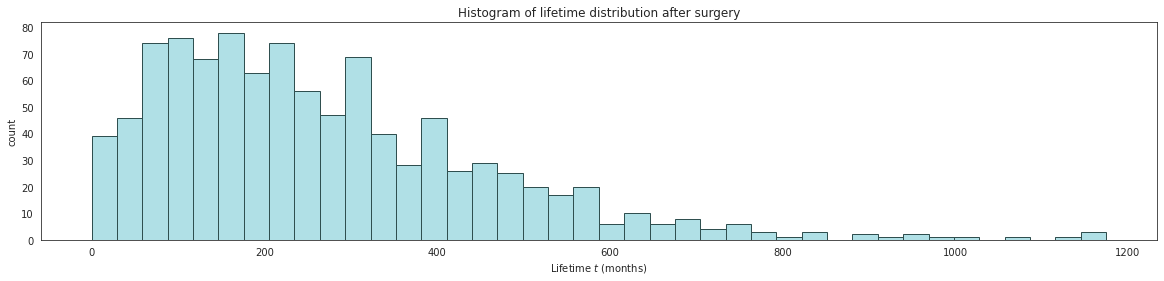

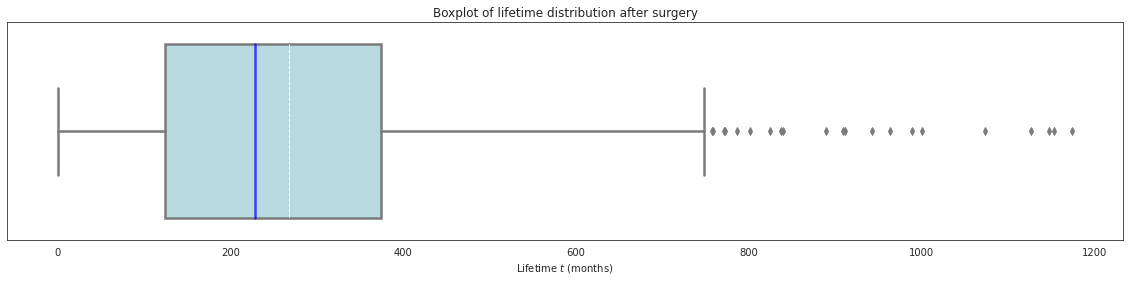

,count,mean,std,min,25%,50%,75%,max
Lifetimes,1000.0,268.032,191.166057,0.0,123.75,228.0,374.25,1175.0


In [ ]:
# Summary of lifetime distribution
fig, ax = plt.subplots(figsize=(20, 4))
ax.hist(lifetimes, bins=40, color="powderblue", edgecolor="darkslategrey")
ax.set(
    xlabel=r"Lifetime $t$ (months)",
    ylabel="count",
    title="Histogram of lifetime distribution after surgery",
)
plt.show()

fig, ax = plt.subplots(figsize=(20, 4))
ax = sns.boxplot(
    x=lifetimes,
    linewidth=2.5,
    color="powderblue",
    medianprops=dict(color="blue", alpha=0.7),
    showmeans=True,
    meanline=True,
    meanprops={"color": "white"},
)
ax.set(
    xlabel=r"Lifetime $t$ (months)",
    title="Boxplot of lifetime distribution after surgery",
)
plt.show()

# Descriptive statistics
df_describe = pd.DataFrame(lifetimes, columns=["Lifetimes"])
display(df_describe.describe().T)

On average, a woman dies around 20 years after breast cancer surgery. By looking at the distribution, it is common for women to die in the first 20 years. Women who live more than 60 years after the surgery make up the tail of the distribution with some outliers living up tp 10,000 months (83 years). Knowing that about 80% of women diagnosed with breast cancer each year are ages 45 or older, we can assume that the women undergoing this surgery are very likely to be in that age range. Thus, their total lifetime would be their age + their lifetime after surgery.

Lastly, we look into the proportion of women cancer eventually reappears locally. We also investigated the proportion of women who went through the other states.

In [ ]:
# In what proportion of women does the cancer eventually reappear, locally (state 2)?
proportion_through_state = np.zeros((N,))
for s in range(N):
    nb = 0
    for i in range(n):
        nb += int(s + 1 in women[:, i])
    nb /= n
    proportion_through_state[s] = nb
    print(f"Proportion of women that went through state {s + 1} is {nb}")

Proportion of women that went through state 1 is 1.0
Proportion of women that went through state 2 is 0.594
Proportion of women that went through state 3 is 0.484
Proportion of women that went through state 4 is 0.384
Proportion of women that went through state 5 is 1.0


In our model, it is evident that 100% of the women went through state 1 (healthy) and state 5 (Dead), as it is the initial and terminal state for every woman. About 60% of the woman reaches state 2, that the cancer eventually reappears locally. Around 50% experience that distant cancer reappers. Around 35% experience both locally and dostant cancer.

## Task 2

In this task we will be using a statistical test invesigate the distribution over the states at a given time $t$. The distributions $\pi_t$ from the simulation can be compared to the analytical distributions using a $\chi^2$-test.

The simulation is first validated by comparing the distribution at the certain time point, $t=120$.

In [ ]:
# Calculate the expected state distributions for all timesteps
PIs_analytical = breast_cancer_analytical(T)

# Given time t
t = 120

# Simulated distribution for t=120
p120_sim = PIs_sim[t, :]
# Analytical distribution for t=120
p120_true = PIs_analytical[t, :]

# Statistical test
n_obs = p120_sim * n
n_exp = p120_true * n

chisq, p_value = stats.chisquare(n_obs, f_exp=n_exp)

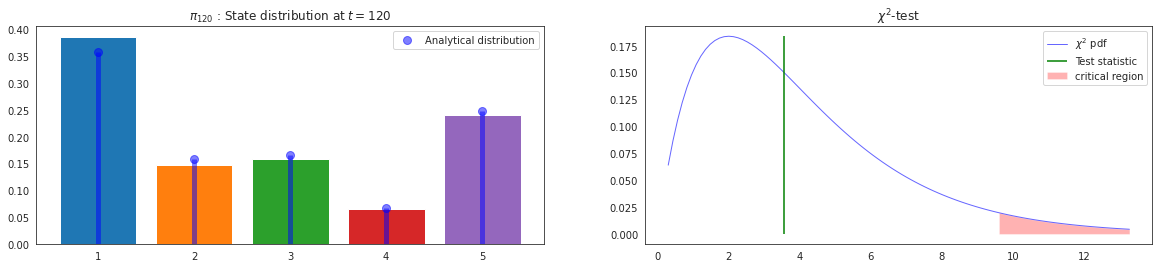

Test statistic: 3.556330783527027
p-value: 0.46936497591493154


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
# Bar plot of distribution pi_120
ax = axes[0]
color_palette = ["C0", "C1", "C2", "C3", "C4"]
x = np.arange(1, N + 1)
ax.plot(x, p120_true, "bo", ms=8, label="Analytical distribution", alpha=0.5)
ax.vlines(x, 0, p120_true, colors="b", lw=5, alpha=0.5)
ax.bar(x=x, height=p120_sim, color=color_palette)
ax.set(title=r"$\pi_{120}$ : State distribution at $t=120$")
ax.legend()

# Chi2 test plot
ax = axes[1]
df = N - 1
x = np.linspace(stats.chi2.ppf(0.01, df), stats.chi2.ppf(0.99, df), 100)
y = stats.chi2.pdf(x, df)
ax.plot(x, y, "b-", lw=1, alpha=0.6, label=r"$\chi^2$ pdf")
ax.vlines(x=chisq, ymin=0, ymax=max(y), color="green", label="Test statistic")
ax.fill_between(
    x,
    0,
    y,
    where=x >= stats.chi2.ppf(0.95, df),
    facecolor="red",
    alpha=0.3,
    interpolate=True,
    label="critical region",
)
ax.set(title=r"$\chi^2$-test")
ax.legend()

plt.show()

print("Test statistic:", chisq)
print("p-value:", p_value)

Visually, the figure on the left shows the empirical distribution as a bar plot with the analytical distribution as vertical lines. We see that the two distributions appear very similar. Then, the figure on the right shows the $\chi^2$-test with $N-1$ degrees of freedom ($N=5$ states, $i.e.$ classes). The test statistic is not in the critical region. Since the p-value > 0.05, the hypothesis that the simulated distribution follows the analytical distribution is not rejected. Thus, we can assume that the simulated proportions of women in each state for $t=120$ correspond to what we expect.

Note that, by definition of the statistical test with $\alpha=0.05$, in 5% of the time the test is going to reject $H_0$ even if $H_0$ holds.

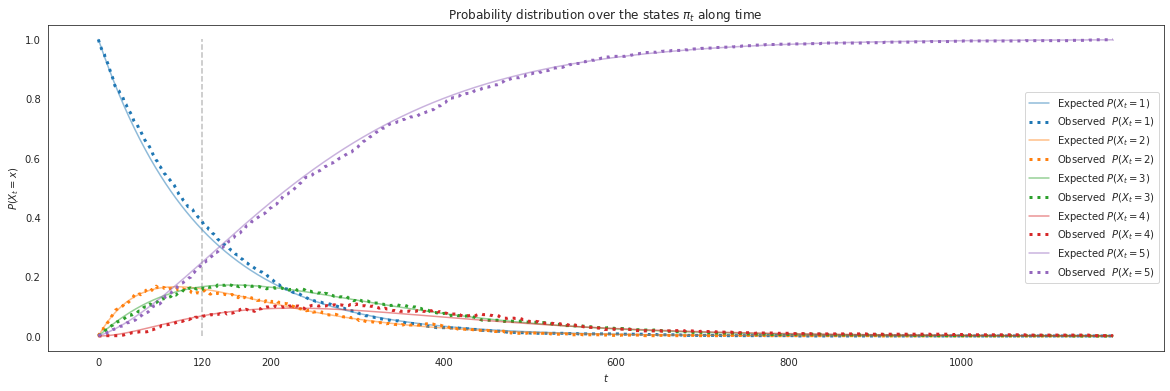

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.vlines(x=120, ymin=0, ymax=1, ls="--", color="grey", alpha=0.5)
for i in range(N):
    ax.plot(
        timesteps,
        PIs_analytical[:, i],
        ls="-",
        alpha=0.5,
        c=color_palette[i],
        label=rf"Expected $P(X_t={i + 1})$",
    )
    ax.plot(
        timesteps,
        PIs_sim[:, i],
        ls=":",
        lw=3,
        alpha=1.0,
        c=color_palette[i],
        label=rf"Observed  $P(X_t={i + 1})$",
    )
    ax.set(
        xlabel=r"$t$",
        ylabel=r"$P(X_t = x)$",
        title=r"Probability distribution over the states $\pi_t$ along time",
    )
    ax.legend()

plt.xticks(list(range(0, T + 1, 200)) + [120])
plt.show()

The figure above shows the evolution of the probability distributions $\pi_t$ along time (for $\pi_0=[1,0,0,0,0]$). 

One can clearly observe that the expected distributions (analytical) and the observed ones (simulated) are very similar. The vertical dashed grey line is the distribution analyzed above at $t=120$. It looks like our simulation corresponds to our expectations for all time steps.

## Task 3
This time instead of validating the simulation at a particular time point, we validate the simulation by ensuring the empirical lifetime distribution matches the theoretical. We want to show that T follows a so-called discrete phase-type distribution. This distribution has a probability mass function. This distribution has probability mass function and means given as:

$$
P(T=t)=\pi_0 (P_s)^t p_s
$$

$$
E(T)= \pi_0 (I-P_s)^{-1}1
$$

Where $\pi_0$ is the distribution over the states 1-5 for $t=0$. $P_s$ is given as the sub-matrix 4x4 of $P$, where the last column and row are removed. $p_s$ is the column vector covering the probability of dying in states 1-4. Finally, 1 is a vector of ones of appropriate dimensions.



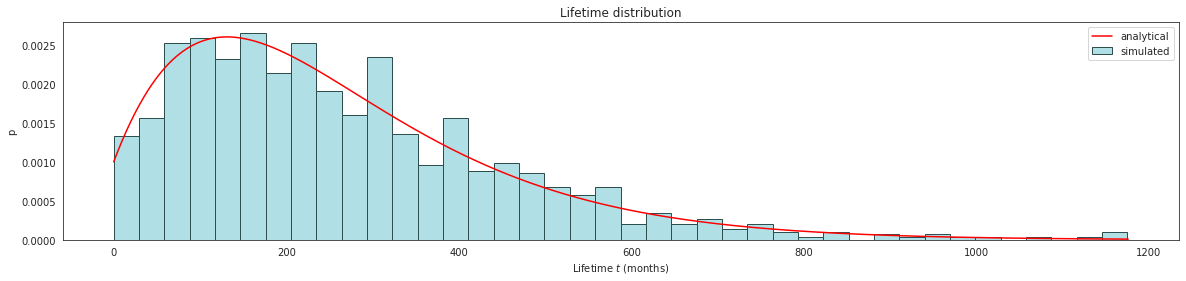

In [ ]:
# probability mass function


def pmf(t, pi, Ps, ps):
    return pi @ np.linalg.matrix_power(Ps, t) @ ps


# probability mass function for the sub-matrix 4x4 of P.
def pmf2(t, p0, P_5x5):
    return pmf(t, p0[:-1], P_5x5[:-1, :-1], P_5x5[:-1, -1])


# mean
def expectation(pi, Ps):
    return pi @ np.linalg.pinv(np.identity(Ps.shape[0]) - Ps) @ np.ones(Ps.shape[0])


# mean for the sub-matrix 4x4 of P.
def expectation2(p0, P_5x5):
    return expectation(p0[:-1], P_5x5[:-1, :-1])


# true lifetimes
lifetimes_true_pmf = np.array([pmf2(t, PIs_sim[0, :], P) for t in timesteps])

# plotting
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(timesteps, lifetimes_true_pmf, color="red", label="analytical")
ax.hist(
    lifetimes,
    bins=40,
    density=True,
    color="powderblue",
    edgecolor="darkslategrey",
    label="simulated",
)
ax.set(xlabel=r"Lifetime $t$ (months)", ylabel="p", title="Lifetime distribution")
ax.legend()
plt.show()

In the above figure, the simulation seems to follow the theoretical distribution. The distribution will be verifed with a $\chi^2$-test because it is a discrete distribution.

In [ ]:
# Chi2 test for lifetimes distributions
bin_width = 100
bins = int(np.ceil(max(lifetimes) / bin_width))  # number of classes
n_obs, bin_edges = np.histogram(lifetimes, bins=bins, range=(0, bin_width * bins))

cdf = np.cumsum(lifetimes_true_pmf)
f_exp = []
for i in range(len(bin_edges) - 2):
    f_exp += [
        cdf[int(bin_edges[i + 1])] - cdf[int(bin_edges[i])]
    ]  # P(z < X < y) = P(X<y) - P(X<z)
f_exp += [1 - np.sum(f_exp)]  # Last bin has probability P(X>x) = 1 - P(X<x)

n_exp = np.array(f_exp) * n

chisq, p_value = stats.chisquare(n_obs, f_exp=n_exp)

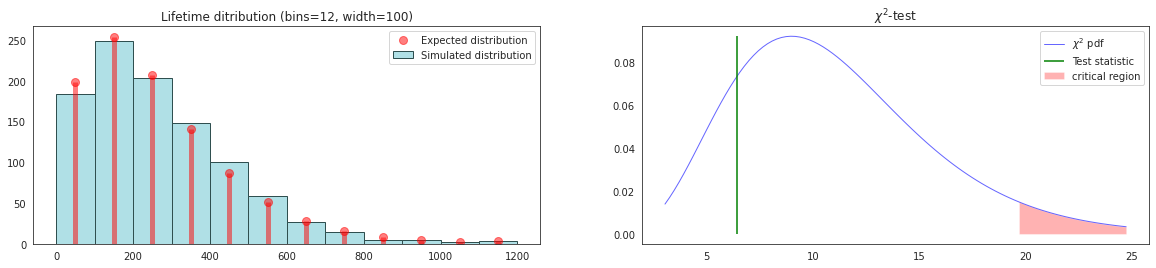

Test statistic: 6.443556697655841
p-value: 0.842192261469128


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
# Bar plot of distribution pi_120
ax = axes[0]
x = np.arange(bin_width / 2, bin_width * bins, bin_width)
ax.plot(x, n_exp, "ro", ms=8, label="Expected distribution", alpha=0.5)
ax.vlines(x, 0, n_exp, colors="red", lw=5, alpha=0.5)
ax.hist(
    lifetimes,
    bins=bins,
    range=(0, bin_width * bins),
    color="powderblue",
    edgecolor="darkslategrey",
    label="Simulated distribution",
)
ax.set(title=rf"Lifetime ditribution (bins={bins}, width={bin_width})")
ax.legend()

# Chi2 test plot
ax = axes[1]
df = bins - 1
x = np.linspace(stats.chi2.ppf(0.01, df), stats.chi2.ppf(0.99, df), 100)
y = stats.chi2.pdf(x, df)
ax.plot(x, y, "b-", lw=1, alpha=0.6, label=r"$\chi^2$ pdf")
ax.vlines(x=chisq, ymin=0, ymax=max(y), color="green", label="Test statistic")
ax.fill_between(
    x,
    0,
    y,
    where=x >= stats.chi2.ppf(0.95, df),
    facecolor="red",
    alpha=0.3,
    interpolate=True,
    label="critical region",
)
ax.set(title=r"$\chi^2$-test")
ax.legend()
plt.show()

print("Test statistic:", chisq)
print("p-value:", p_value)

Since the p-value > 0.05, the hypothesis that the simulated distribution follows the analytical distribution is not rejected.
The plot of the left shows the lifefetimes divided into $bins$ classes and the plot on the right shows the $\chi^2$-test. 

Here, we show the lifetimes divided into 12 classes, each of width 100 months. The last class accounts for lifetimes in $[1100,\infty]$. We experimented with dividing the distribution into multiple numbers of classes. Each time, the test did not reject the null hypothesis.

Note that with bins of width 1, this is equivalent to have one class per timestep $t$.

This is also investigated by calculating the Confidence interval.

Confidence interval for the mean of $n$ estimates, $\hat{\theta}_1,\dots,\hat{\theta}_2$:
$$
\bar{\theta} = \frac{\sum_{i=1}^n\hat{\theta}_i}{n}
$$
$$
S_{\theta}^2 = \frac{1}{n-1}\sum_{i=1}^n(\hat{\theta}_i^2 - \bar{\theta})
$$
$$
\left[\bar{\theta} + \frac{S_{\theta}}{\sqrt{n}} t_{\frac{\alpha}{2}}\: ; \: \bar{\theta} + \frac{S_{\theta}}{\sqrt{n}} t_{1-\frac{\alpha}{2}} \right]
$$
where $t$ is the quantile from the t-distribution with $n-1$ degrees of freedom.


In [ ]:
def confidence_interval_mean(X, alpha=0.05):
    n = len(X)
    mean = np.mean(X)
    var = np.var(X, ddof=1)
    qt = stats.t.interval(1 - alpha, df=n - 1)
    conf = mean + np.array(qt) * np.sqrt(var) / np.sqrt(n)
    return conf

In [ ]:
alpha = 0.05
lifetime_conf = confidence_interval_mean(lifetimes, alpha)

lifetime_mean_analytical = expectation2(PIs_sim[0, :], P)
lifetime_mean = np.mean(lifetimes)
print("analytical - mean:", lifetime_mean_analytical)
print(
    "simulation - mean: {}, {}%-confidence interval: {}".format(
        lifetime_mean, (1 - alpha) * 100, lifetime_conf
    )
)

analytical - mean: 262.37161531279315
simulation - mean: 268.032, 95.0%-confidence interval: [256.16925041 279.89474959]


Notice, the analytical mean is within the 95% confidence interval of the simulated mean.

## Task 4

In this task, we want to simulate 1000 women who meet specific requirements. The requirement is that we want women who survive the first 12 months following surgery, but their breast cancer has also reappeared within the first 12 months, either locally or distant. 

To estimate these 1000 women, we start by simulating a large number of women that hopefully has enough that relapse. Then we filter for the woman that survives and cancer has reappeared in the first 12 months. Then we can check that the simulation cover 1000 women. If not, we will increase the first simulation number.

The estimated expected lifetime is presented in a histogram below.

In [ ]:
# simulate women (assuming 20000 has enough that relapse)
women_relapsed, lifetime_relapsed, _, _ = breast_cancer_simulation(
    P, n=20000, Tmax=2000
)

# filter women who: who, in the first 12 months, survived but relapsed
survived_idx = np.argwhere(women_relapsed[12, :] < 5)  # survived
relapsed_idx = np.argwhere(women_relapsed[12, :] > 1)  # relapsed

filtered_idx = np.intersect1d(survived_idx, relapsed_idx)

if len(filtered_idx) < 1000:
    print(f"Not enough women simulated! {len(filtered_idx)}/1000")

# Take 1000 acceptable simulations
women_relapsed = women_relapsed[:, filtered_idx[:1000]]
lifetime_relapsed = lifetime_relapsed[filtered_idx[:1000]]

Expected lifetime: 175.07 months for relapsed women


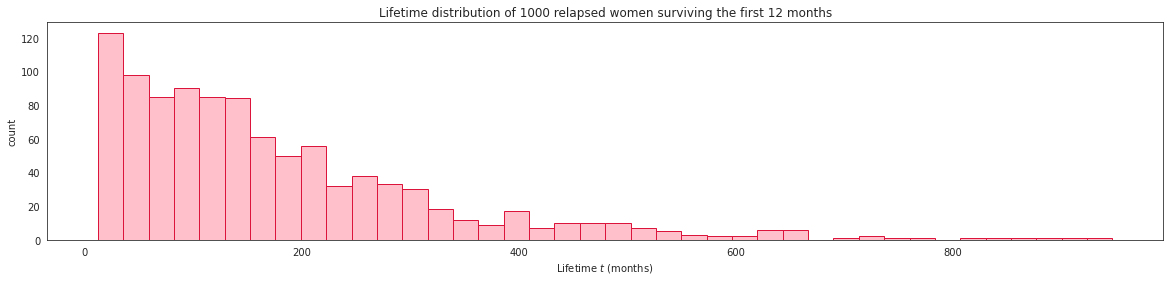

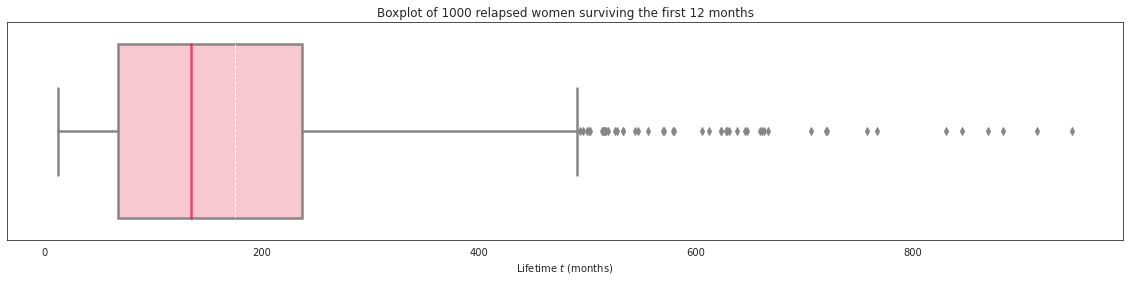

,count,mean,std,min,25%,50%,75%,max
lifetime_relapsed,1000.0,175.071,150.167841,12.0,67.0,135.0,237.25,947.0


In [ ]:
# Summary of lifetime distribution
print(f"Expected lifetime: {np.mean(lifetime_relapsed):3.2f} months for relapsed women")

fig, ax = plt.subplots(figsize=(20, 4))
ax.hist(lifetime_relapsed, bins=40, color="pink", edgecolor="crimson")
ax.set(
    xlabel=r"Lifetime $t$ (months)",
    ylabel="count",
    title="Lifetime distribution of 1000 relapsed women surviving the first 12 months",
)
plt.show()

fig, ax = plt.subplots(figsize=(20, 4))
ax = sns.boxplot(
    x=lifetime_relapsed,
    linewidth=2.5,
    color="pink",
    medianprops=dict(color="crimson", alpha=0.7),
    showmeans=True,
    meanline=True,
    meanprops={"color": "white"},
)
ax.set(
    xlabel=r"Lifetime $t$ (months)",
    title="Boxplot of 1000 relapsed women surviving the first 12 months",
)
plt.show()

# Descriptive statistics
df_describe = pd.DataFrame(lifetime_relapsed, columns=["lifetime_relapsed"])
display(df_describe.describe().T)

Obviously, in this case the minimum value of lifetimes is $\geq 12$. The maximum lifetime is lower than before, i.e. it seems like the woman that lived for a very long time previously were not wowen that relapsed in the first year.

For these women, their lifetime is shorter on average—they live about 14 years after surgery. This sample distribution looks different from the one with all types of women. Here, it peaks sooner and steadily decreases over time. It is maybe close to an exponential distribution.

## Task 5
In this task, we want to investigate the fraction of women that will die in the first 350 months. First, we are simulation 200 women to calculate the fraction and repeat this 100 times. This method is also called Crude Monte Carlo estimation. Then, to reduce variance, we use the mean lifetime after surgery of the 200 simulations as control variates (see formula below).

$Z = X + c * (Y - \bar Y)$,

where 

$c = \frac{-Cov(X, Y)} {Var(Y)}$


In [ ]:
def compute_estimator(N_repeats, N_women, T_max):
    X = []  # Crude Monte Carlo estimators : fraction of survivors
    Y = []  # Control variates : mean lifetime after surgery

    # make N_repeats
    for i in range(N_repeats):
        # simulate for N_women
        women_die, lifetime_die, _, _ = breast_cancer_simulation(
            P, n=N_women, Tmax=T_max
        )
        # Count number of dead women
        died = (women_die[350, :] == 5).sum()

        # fraction of women who died
        X += [died / N_women]
        Y += [np.mean(lifetime_die)]

    # convert to numpy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [ ]:
def visualize_results(confidence_inters, truth=None):
    methods_idx = {
        k: i
        for k, i in zip(
            confidence_inters.keys(), np.arange(1, len(confidence_inters) + 1)
        )
    }
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    if truth:
        ax.vlines(
            x=truth,
            ymin=0,
            ymax=len(confidence_inters) + 1,
            linestyles="--",
            color="grey",
            label="Truth",
        )

    for method, interval in confidence_inters.items():
        ax.plot(interval, np.full((2,), methods_idx[method]), marker="o", label=method)
    ax.legend()
    ax.set(xlabel="Confidence interval", ylabel="Simulation")
    ax.set_yticks([])
    plt.show()

Estimated mean: 0.7358500000000001, Difference from true mean: 0.002036800587965626
Estimated mean: 0.7358500000000001, Difference from true mean: 0.002036800587965626
Control Variate -> reduction in variance: 0.000524670702690182


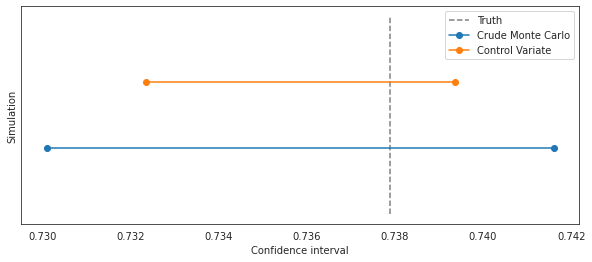

In [ ]:
# run the fraction calculator crude monte carlo estimator
N_repeats = 100
N_women = 200
T_max = 2000  # 350

X, Y = compute_estimator(N_repeats, N_women, T_max)

# truth: women dead within 350 months
truth = PIs_analytical[350, 4]

# initial lists
confidence_inters = {}
estimates_var = {}

# Calculate expected mean - Crude monte carlo
point_estimate = np.mean(X)
print(
    f"Estimated mean: {point_estimate}, Difference from true mean: {abs(point_estimate - truth)}"
)

# Add to the lists
confidence_inters["Crude Monte Carlo"] = confidence_interval_mean(X, alpha=0.05)
estimates_var["Crude Monte Carlo"] = np.var(X)

# Control variate (expected lifetime after surgery)
mu_Y = np.mean(Y)
c = -np.cov(X, Y)[0][1] / np.var(Y)
# New estimator: variable Z
Z = X + c * (Y - mu_Y)
point_estimate = np.mean(Z)
print(
    f"Estimated mean: {point_estimate}, Difference from true mean: {abs(point_estimate - truth)}"
)

# Add to the lists
confidence_inters["Control Variate"] = confidence_interval_mean(Z, alpha=0.05)
estimates_var["Control Variate"] = np.var(Z)

print(
    "Control Variate -> reduction in variance:",
    abs(estimates_var["Control Variate"] - estimates_var["Crude Monte Carlo"]),
)

visualize_results(confidence_inters, truth)

The fraction of women who dies within the first 350 months (before the age of 30) is computed from the number of women in state five according to the Expected distribution $\pi_{t=350}$. The reduction in variance is marginal.

## Task 6

Assumptions underlying the discrete time Markov chain model:

* Women do not undergo another surgery after either a local or distant ressurgence appears (state 1 is not accessible from state 2,3 or 4).

* We observed the case whe some women have a lifetime of more than 100 years after surgery. This is not realistic.

* The model only considers 5 different states and only two kinds of cancer reappearance. There might be more types of cancer, with different survival rate. 


* The discrete Markov chain assumes transitions occur once a month. However, transitions for the breast-cancer model should occur continously. Thus, a continuous-time Markov chain is applicable. 

# Part 2: A continuous-time model

In the previous part, we assumed transitions from one state to another only
happened once a month. In a more realistic model, transitions may occur
at any time. Markov chains where transitions occur in continuous time are
called Continuous-Time Markov Chains (CTMC). A CTMC is specified by
a transition-rate matrix.

$$
Q = \begin{bmatrix} q_{11} & q_{12} & \cdots & q_{1N} \\ q_{21} & q_{22} & \cdots & q_{2N} \\ \vdots & \vdots & \ddots & \vdots \\ q_{N1} & q_{N2} & \cdots & q_{NN} \end{bmatrix}
$$

## Task 7

As before, we choose one time-unit equal to one month.

Use transition matrix $Q$ below.

Simulate 1000 women, all starting in state 1, until death. Summarize the
lifetime distribution after surgery, for example in a histogram. Report the
mean, along with a confidence interval, and the standard deviation, also
with a confidence interval. In what proportion of women has the cancer
reappeared distantly after 30.5 months?

In [ ]:
Q = [
    [-0.0085, 0.005, 0.0025, 0, 0.001],
    [0, -0.014, 0.005, 0.004, 0.005],
    [0, 0, -0.008, 0.003, 0.005],
    [0, 0, 0, -0.009, 0.009],
    [0, 0, 0, 0, 0],
]
Q = np.array(Q)

After the sojourn time is up in state $i$, the CTMC jumps to state $j$ with probability $\dfrac{-q_{ij}}{q_{ii}}$ given $i \neq j$. 

If $i = j$ the transition probability becomes negative so it is set to 0.

In [ ]:
def sample_q(i):
    ### starting in state i, compute probabilities of moving to state 0...k
    probs = [-Q[i][k] / Q[i][i] for k in range(Q.shape[1])]

    ### -Q[k][k]/Q[k][k] = -1
    ### can't move to same state so set probability to 0 where its -1
    probs = [0.0 if x < 0.0 else x for x in probs]

    ### pick a new state based on probabilities defined before
    i_star = np.random.choice([0, 1, 2, 3, 4], p=probs)

    return i_star

The sojourn time in state $i$ is exponentially distributed with rate $-q_{ii}$. If a person is dead (i.e. in state 5) we set the sojourn time to infinity.

In [ ]:
def sj_time_point(Q, i):
    if i == Q.shape[0] - 1:  ### person is dead so not transitioning ever
        return np.inf
    else:
        return np.random.exponential(scale=1 / -Q[i][i])

In [ ]:
### initialise list of lists
### with each person having state 0 and waiting time = sj_times[0]


def init_people(n):
    ### lst = [(state, time left), (state, time left) ... ]
    lst = []
    for _ in range(n):
        lst.append((0, sj_time_point(Q, 0)))
    return np.array(lst)

We now show the main loop of the simulation program for the continuous case. We have $n$ women and a maximum iteration limit period $T$. $T$ is given to initialise the sizes of the arrays ```women``` and ```alive```. The two arrays hold information on the state of each woman at timestep $t$ and the number of women alive at timestep $t$ respectively. Timestep $t$ is the actual continuous time and is incremented based on an event list. The simulation terminates when all women are dead. Since we don't know when the simulation would end, we use $i$ to track the iteration of the simulation program and provide that information. As before the aim of the program is to update the state of every woman when the sojourn period is up for that woman. The state is updated based on probabilies calculated using values from the matrix $Q$. This is done in the ```sample_q(i)``` function above. After a state update, a new sojourn time is drawn using the ```sj_time_point(Q, i)``` function above.

The program follows the following steps:

* **Step 1:** Initialization. All women are healthy. For each woman we draw the sojourn time for being in state 0 (healthy). We store both the state and sojourn time for each woman. This is the event list ```people```.
* **Step 2:** While atleast one alive:  
    * **Step 3:** We extract the minimum sojourn time ```next_event_time``` from the event list. 
    * **Step 4:** If ```next_event_time``` is infinity then everyone is dead and we exit the simulation.
    * **Step 5:** For each woman in the event list we update the sojourn time by subtracting ```next_event_time``` from the sojourn time. 
    * **Step 6:** For all women where the updated time is 0, we transition to a new state and update the sojourn time by drawing a new time for being in that state.
    * **Step 7:** We update timestep $t$ to the ```next_event_time```.
    * **Step 8:** We increment $i$.

Below is the program presented.


In [ ]:
def ctmc_sim(Q, n, T):
    t = 0

    people = init_people(n)  ### [(state, time left), (state, time left) ... ]
    lifetime = np.zeros((n,))
    alive = np.zeros((T, 2))  ### [[t1, no.alive], [t2, no.alive] ... ]
    alive[0, :] = [0, n]
    women = np.zeros(
        (T, n + 1)
    )  # Timestep column + n women columns: [[t1, states], [t2, states], [ t3, states]...]

    i = 0
    while True:
        ### extract min waiting time from people list
        next_event_time = np.min([x[1] for x in people])

        ### if min is np.inf exit loop as everyone is dead
        if next_event_time == np.inf:
            break

        ### subtract waiting times in people list with next_event_time
        people = np.array([(x[0], x[1] - next_event_time) for x in people])

        ### for all people with remaining waiting time == 0 update their state
        ### first update state
        people = np.array(
            [
                (sample_q(int(x[0])), x[1]) if x[1] == 0.0 else (x[0], x[1])
                for x in people
            ]
        )

        ### then update waiting time by drawing a new waiting time from exp()
        people = np.array(
            [
                (x[0], sj_time_point(Q, int(x[0]))) if x[1] == 0.0 else (x[0], x[1])
                for x in people
            ]
        )

        people_times = np.array([x[1] for x in people])
        ### get indices of alive people
        idx = np.argwhere(people_times != np.inf)

        ### move time forward
        t += next_event_time

        ### update lifetimes
        lifetime[idx] = t

        ### update index
        i += 1

        ### extract updated states for each woman
        updated_states = [x[0] for x in people]
        ### put timestep in 0'th index
        updated_states = np.insert(updated_states, 0, t)
        ### append
        women[i, :] = np.array(updated_states)

        ### update number of women alive
        alive_counts = [1 if x[1] != np.inf else 0 for x in people]
        alive_counts = np.array(np.sum(np.array(alive_counts)))
        ### insert timestamp
        alive_counts = np.insert(alive_counts, 0, t)
        alive[i, :] = np.array(alive_counts)

    return lifetime, people, t, women[: i + 1, :], alive[: i + 1, :], i

In [ ]:
lifetime, people, t, women, alive, end_index = ctmc_sim(Q, n, T=5000)

In [ ]:
### assert that all women are dead at end of simulation
assert np.all(people[:, 1] == np.inf)  ### time is np.inf
assert np.all(people[:, 0] == 4)  ### state is 4
assert np.all(women[-1, 1:].astype(np.int32) == 4)  ### state is 4
print(
    "Simulation ended, i.e. all women died, after {} months ({:.2f} years).".format(
        t, t / 12
    )
)

Simulation ended, i.e. all women died, after 1243.440722759823 months (103.62 years).


The simulation ends when all women are dead. Similar to before we see this happens after about 100 years and again it is unrealistic for a person to live that long.

Next, we look at a histogram of the lifetime distribution and a boxplot.

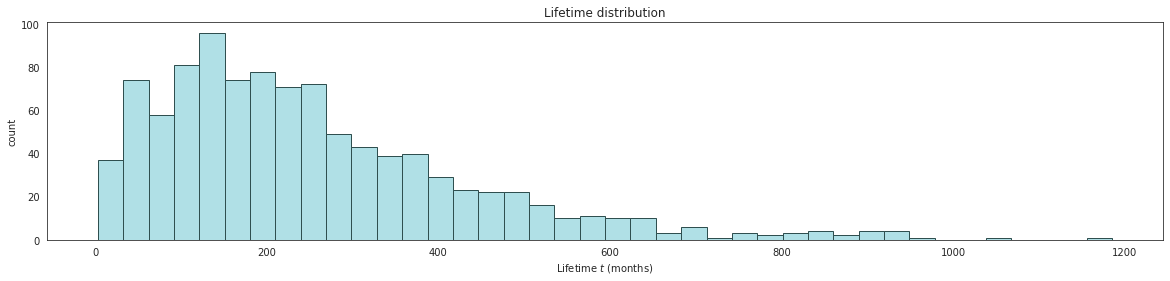

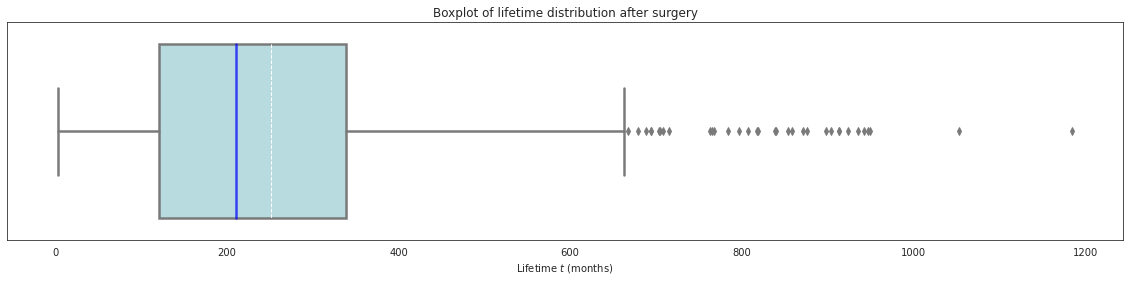

,count,mean,std,min,25%,50%,75%,max
Lifetimes,1000.0,251.902768,183.319863,3.117901,121.442051,210.711374,338.985305,1185.32112


In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.hist(lifetime, bins=40, color="powderblue", edgecolor="darkslategrey")
ax.set(xlabel=r"Lifetime $t$ (months)", ylabel="count", title="Lifetime distribution")
plt.show()

fig, ax = plt.subplots(figsize=(20, 4))
ax = sns.boxplot(
    x=lifetime,
    linewidth=2.5,
    color="powderblue",
    medianprops=dict(color="blue", alpha=0.7),
    showmeans=True,
    meanline=True,
    meanprops={"color": "white"},
)
ax.set(
    xlabel=r"Lifetime $t$ (months)",
    title="Boxplot of lifetime distribution after surgery",
)
plt.show()

# Descriptive statistics
df_describe = pd.DataFrame(lifetime, columns=["Lifetimes"])
display(df_describe.describe().T)

We see a similar trend to the discrete case, where on average a woman dies about 22 years after surgery. Again, looking at the boxpot women who die about 60 years after surgery would be considered outliers. The lifetime dsitribution follows a similar trend to the discrete case.

Next we compute the confidence intervals for the mean and standard deviations.

Confidence interval for the standard deviation of $n$ estimates, $\hat{\theta}_1,\dots,\hat{\theta}_2$:

$$
\left[\sqrt{\frac{(n-1)S_{\theta}^2}{\chi^2_{1-\alpha/2}}}, \sqrt{\frac{(n-1)S_{\theta}^2}{\chi^2_{\alpha/2}}} \right]
$$

where the quantiles come from a $\chi^2$-distribution with $n-1$ degrees of freedom.

In [ ]:
def confidence_interval_std(estimates, perc=0.95):
    n = len(estimates)
    mean = np.mean(estimates)
    var = np.var(estimates, ddof=1)

    alpha = 1 - perc
    qt = stats.chi2.interval(1 - alpha, df=n - 1)

    lower = np.sqrt(((n - 1) * var) / qt[1])
    upper = np.sqrt(((n - 1) * var) / qt[0])
    return lower, upper

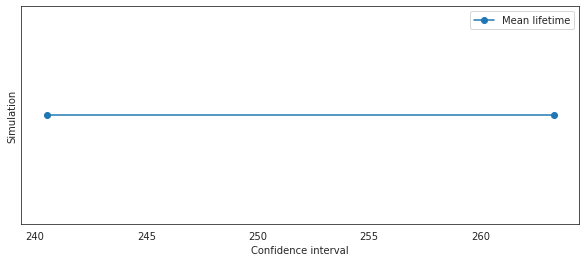

Mean: 251.90276752260786
Confidence interval: [240.52691107 263.27862398]


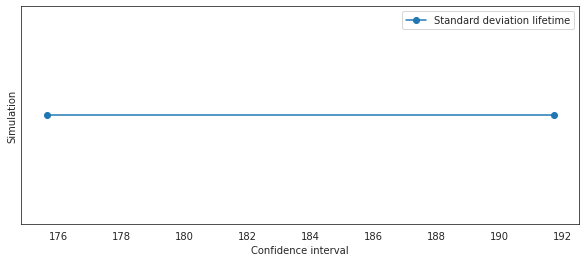

STD: 183.22817988796515
Confidence interval: (175.6226923503924, 191.72789376867058)


In [ ]:
conf_mean = {"Mean lifetime": confidence_interval_mean(lifetime)}
visualize_results(conf_mean)
print("Mean:", np.mean(lifetime))
print("Confidence interval:", conf_mean["Mean lifetime"])

conf_std = {"Standard deviation lifetime": confidence_interval_std(lifetime)}
visualize_results(conf_std)
print("STD:", np.std(lifetime))
print("Confidence interval:", conf_std["Standard deviation lifetime"])

We see that both the mean and standard deviations for this run of the simulation fall within the 95% confidence intervals.

Next we define a function to get the proportion of women where the cancer reappeared after 30.5 months. 

In [ ]:
t_ = 30.5
# Index of the row with timestamp closest to 30.5 months (but not above)
idx = np.argwhere(women[:, 0] < t_).flatten()[-1]

for s in range(N):
    proportion = 0
    for col in range(1, women.shape[1]):
        # Check if the woman went through state s
        if s in women[: idx + 1, col]:
            proportion += 1
    proportion /= n
    print(
        "After {} months, proportion of women that went through state {} is {}".format(
            t_, s + 1, proportion
        )
    )

After 30.5 months, proportion of women that went through state 1 is 1.0
After 30.5 months, proportion of women that went through state 2 is 0.136
After 30.5 months, proportion of women that went through state 3 is 0.088
After 30.5 months, proportion of women that went through state 4 is 0.008
After 30.5 months, proportion of women that went through state 5 is 0.036


After 30.5 months, the proportion of women whose cancer reappeared distantly is 7.1%.

## Task 8
In this task, we want to validate the simulation by ensuring the empirical lifetime distribution matches the theoretical. We want to show that the lifetime distribution now follows a continuous-time phase-type distribution. Given as:

$$
F_T(t)=1-p_0 \exp(Q_st)1
$$

Where the last column and row are removed, where $Q_s$ is given as the sub-matrix 4x4 of $Q$. Finally, 1 is a vector of ones of appropriate dimensions. $\exp(Qst)$ is the matrix exponential of the matrix $Q_st$. It is defined as the infinite sum:

$$
\exp(Q_st)=\sum^\infty_{i=1} \frac{(Q_{s}t)^i}{i!}
$$

We are using the appropriate statistical test Kolmogorov Smirnov test and the program is presented below.

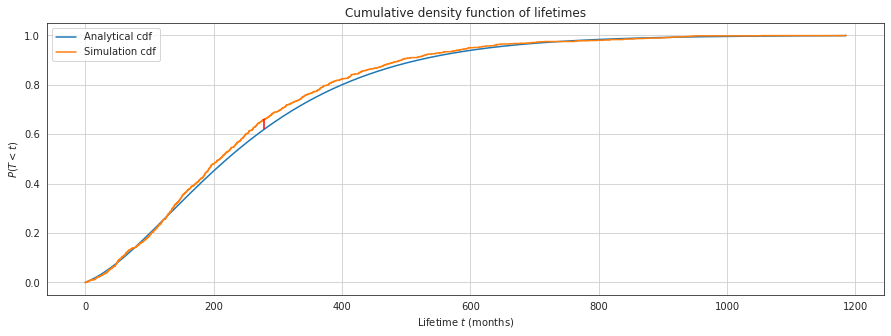

The null hypothesis is rejected since D = 0.040855 > D_α = 0.038534


In [ ]:
# Calculate the continuous-time phase-type distribution


def cdf(p0, Qs, t):
    return 1 - p0 @ expm(Qs * t) @ np.ones(p0.size)


def kolmogorov_smirnov_test(
    lifetimes, alpha=0.05, ticks=1000, minimumT=1000, plot_cdf=False
):
    T = max(minimumT, max(lifetimes))

    step_by = T / float(ticks)
    timesteps = np.arange(0, T, step_by)

    cdf_true = np.array([cdf(p0, Qs, t) for t in timesteps])
    cdf_sim = np.array([np.sum(lifetimes <= t) / lifetimes.size for t in timesteps])

    gaps = np.abs(cdf_sim - cdf_true)
    idx_max = np.argmax(gaps)

    Dn = gaps[idx_max]
    Dt = timesteps[idx_max]

    if plot_cdf:
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.plot(timesteps, cdf_true, label="Analytical cdf")
        ax.step(timesteps, cdf_sim, label="Simulation cdf")
        ax.set(
            xlabel=r"Lifetime $t$ (months)",
            ylabel=r"$P(T < t)$",
            title="Cumulative density function of lifetimes",
        )
        ax.legend()
        ax.vlines(
            x=Dt,
            ymin=cdf_true[idx_max],
            ymax=cdf_sim[idx_max],
            color="red",
            label="Maximum D",
        )
        ax.grid(True)
        plt.show()

    criticalValue = stats.ksone.ppf(1 - alpha, n)  # one-sided

    # pval = scipy.special.kolmogorov(Dn*np.sqrt(n)) / 2 #two-sided
    pval = scipy.special.smirnov(n, Dn)  # one-sided

    if Dn <= criticalValue:
        print(
            "The null hypothesis is not rejected since D = %f < D_α = %f"
            % (Dn, criticalValue)
        )
    else:
        print(
            "The null hypothesis is rejected since D = %f > D_α = %f"
            % (Dn, criticalValue)
        )

    return pval, Dn, criticalValue


Qs = Q[:-1, :-1]
p0 = np.array([1, 0, 0, 0])

pval, T, crit = kolmogorov_smirnov_test(lifetime, plot_cdf=True)
# print('Kolmogorov Smirnov Test: p={}, T={}, Crit={}'.format(pval, T, crit))

By just looking at the cumulative density function of lifetime, the analytical and the simulated are almost identical. Therefore, the hypothesis that the simulated distribution follows the analytical distribution is not rejected for the statistical test since the $D < D_\alpha$. 

## Task 9
In this task, we want to investigate if certain preventative treatment influences the lifetime. We are given a new transition-rate matrix $Q$ for women who have received the treatment. To compare lifetime of women given treatment vs. women not given treatment we use their suvival fuctions given as:

$$
S(t) = P(T>t)
$$

And the unbiased estimator of the survival function, which is the Kaplan-Meier estimator, given as:

$$
\hat S(t)=\frac{n-d(t)}{n}
$$

Where $n$ is the number of woman and $d(t)$ is the number of woman who had died at time $t$.

For this new $Q$ we are simulating 1000 women and plot the Kaplan-Meier estimate of the survival function. In the same figure we are also plotting Kaplan-Meier estimate of the survival function this time for women not reciving the treatment. In this way we can compare if the treatment have an effect.

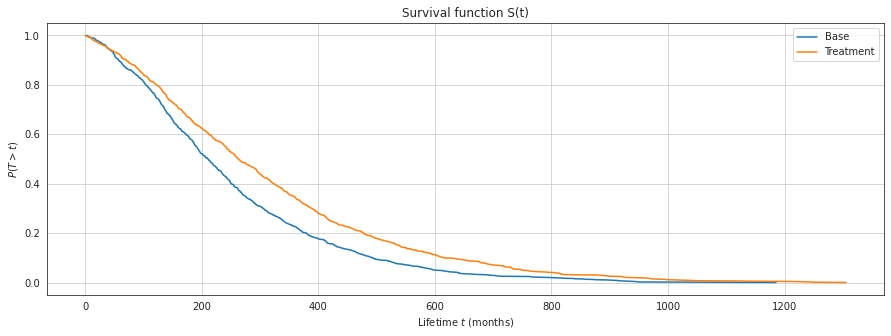

In [ ]:
n = lifetime.size

### Base Simulation ###
lifetimes_base_sorted = np.sort(lifetime)
cdf_base_sim = np.arange(n) / n
survival_proportion_base = 1 - cdf_base_sim


### Treatment Simulation ###
Q_treatment = np.array(
    [
        [-(0.0025 + 0.00125 + 0 + 0.001), 0.0025, 0.00125, 0, 0.001],
        [0, -(0 + 0 + 0.002 + 0.005), 0, 0.002, 0.005],
        [0, 0, -(0 + 0 + 0.003 + 0.005), 0.003, 0.005],
        [0, 0, 0, -(0 + 0 + 0 + 0.009), 0.009],
        [0, 0, 0, 0, -0],
    ]
)

lifetime_treatment, _, _, _, _, _ = ctmc_sim(Q_treatment, n, T=5000)

lifetimes_treatment_sorted = np.sort(lifetime_treatment)
cdf_treatment_sim = np.arange(n) / n  # actually redundant
survival_proportion_treatment = 1 - cdf_treatment_sim


### Plotting ###
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(lifetimes_base_sorted, survival_proportion_base, label="Base")
ax.plot(lifetimes_treatment_sorted, survival_proportion_treatment, label="Treatment")
ax.set(
    xlabel=r"Lifetime $t$ (months)",
    ylabel=r"$P(T > t)$",
    title="Survival function S(t)",
)
ax.legend()
ax.grid(True)
plt.show()

The treatment appears to have a positive effect. The survival rate is larger at all times when using the new treatment compared to no treatment.

## Task 10

[Logrank test - Wikipedia](https://en.wikipedia.org/wiki/Logrank_test)

"Consider two groups of patients, e.g., treatment vs. control. Let $1,\dots,J$ be the distinct times of observed events in either group. 

Let $N_{1,j}$ and $N_{2,j}$ be the number of subjects "at risk" (who have not yet had an event or been censored) at the start of period $j$ in the groups, respectively. 

Let $O_{1,j}$ and $O_{2,j}$ be the observed number of events in the groups at time $j$.

Finally, define $N_j = N_{1,j} + N_{2,j}$ and $O_{j} = O_{1,j} + O_{2,j}$.

The null hypothesis $H_0$ is that the two groups have identical hazard functions."

Under $H_0$, the random variable $O_{i,j}$ follows a hypergeometric distribution with expectation $E_{i,j} = N_{i,j}\frac{O_j}{N_j}$ and variance 
$V_{i,j} = E_{i,j}\frac{N_j - O_j}{N_j}\frac{N_j - N_{i,j}}{N_j - 1}$.

Logrank statistic (for $i=1,2$) for sufficiently large $J$:
$$
Z_i = \frac{\sum_{j=1}^{J}(O_{i,j}-E_{i,j})}{\sqrt{\sum_{j=1}^{J}V_{i,j}}}
$$

Then, under $H_0$, it argued that 
$$
Z \sim N(0,1) \:\:\:\:\:\text{or}\:\:\:\:\: Z^2 \sim \chi^2_1
$$

Additional source: [Stanford univeristy - STAT331 Logrank Test](https://web.stanford.edu/~lutian/coursepdf/unitweek3.pdf)

Here, an event is the death of a patient. We have $J=2000$ distinct event timestamps. Indeed, there are 1000 events from the control group and 1000 from the treatment group and in this case no two events occured at the exact same timestamp ($t$ is continuous).

In [ ]:
### Log-rank test ###
events = np.array([lifetimes_base_sorted, lifetimes_treatment_sorted])
lifetimes_merged = np.sort(
    np.concatenate((lifetimes_base_sorted, lifetimes_treatment_sorted))
)
J = lifetimes_merged.shape[0]

Nij = np.zeros((2, J))
Oij = np.zeros((2, J))
for i in range(2):
    for j in range(J):
        event_time = lifetimes_merged[j]
        Nij[i, j] = len(np.argwhere(events[i, :] > event_time).flatten())
        Oij[i, j] = len(np.argwhere(events[i, :] == event_time).flatten())

Nj = np.sum(Nij, axis=0)
Oj = np.sum(Oij, axis=0)

Eij = np.zeros((2, J))
Vij = np.zeros((2, J))
for i in range(2):
    for j in range(J - 2):
        Eij[i, j] = Nij[i, j] * Oj[j] / Nj[j]  # Last event divide by zero
        Vij[i, j] = (
            Eij[i, j] * ((Nj[j] - Oj[j]) / Nj[j]) * ((Nj[j] - Nij[i, j]) / (Nj[j] - 1))
        )  # Last 2 events divide by zero

Zi = np.zeros((2,))
for i in range(2):
    Zi[i] = np.sum((Oij - Eij), axis=1)[i] / np.sqrt(np.sum(Vij, axis=1)[i])

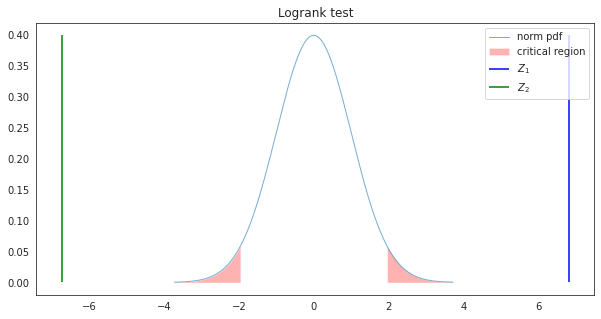

Test statistic Z2 = -6.72674535659628
p-value = 5.959257802167006e-11


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
x = np.linspace(stats.norm.ppf(0.0001), stats.norm.ppf(0.9999), 500)
y = stats.norm.pdf(x)
ax.plot(x, y, "-", lw=1, alpha=0.6, label="norm pdf")
ax.fill_between(
    x,
    0,
    y,
    where=x >= stats.norm.ppf(0.975),
    facecolor="red",
    alpha=0.3,
    label="critical region",
)
ax.fill_between(x, 0, y, where=x <= stats.norm.ppf(0.025), facecolor="red", alpha=0.3)
ax.vlines(x=Zi[0], ymin=0, ymax=max(y), color="blue", label=r"$Z_1$")
ax.vlines(x=Zi[1], ymin=0, ymax=max(y), color="green", label=r"$Z_2$")
ax.set(title="Logrank test")
ax.legend()
plt.show()

p_value = stats.norm.pdf(Zi[1])
print(f"Test statistic Z2 = {Zi[1]}")
print(f"p-value = {p_value}")

We see that the test statistic is in the critical region (p-value < 0.05). Therefore, we reject the null hypothesis $H_0$. We have significant evidence to show that the two survival curves are different. 

## Task 11

What assumptions have been eliminated, by going from the discrete to the continuous time model?
What have been added? How could the model be extended, such that the
sojourn times are Erlang distributed?


* We no longer assume that women can only change state on a monthly basis but now at any continuous time. This results in the model being able to capture more details for the lifetime months. Now, the simulations are now able to simulate when a women died down to a precise timestamp (relative to the surgery).

* We keep the assumption that a woman cannot go to any previous state from the current state. So for example cannot go from state 4 to either 3, 2 or 1.

* In the context of the markov model we no longer assume that a transition can occur to the current state. When the sojourn time is up the state must change to a different state.

* The Erlang distribution is specified by two parameters, the shape $k$ and the rate $\lambda$. The sojourn times can be extended to follow a Erlang distribution by fixing the shape $k$ for each state and defining the rate $\lambda$ similiarly as done when using the exponential distribution for sojourn time. Setting $k=1$ simplifies to an exponential distribution. If desired larger $k's$ can be set to shift the density to the right such that larger sojourn times are sampled.

# Part 3: Estimation

## Task 12

In this task, a time series will be created for each women simulated using the same $Q$ as previously. A total of 1000 time series will be created. A time series contains the state of a given women at every $48$th month, i.e $$Y^{(i)} = (X(0), X(48), X(94), ...,) $$. The time series continues until death, thus the last value in each of the time series should be 5.

In [ ]:
_, _, _, women2, _, _ = ctmc_sim(Q, n=1000, T=5000)

In [ ]:
def extract_timeseries(women, t_between=48):
    timeseries = []
    timeseries.append(women[0, :])  # first check-up
    checkup_id = 1
    for i in range(1, women.shape[0]):
        timestamp = women[i, 0]

        current_checkup_id = int(np.floor(timestamp / t_between))
        delta = current_checkup_id - checkup_id

        # Catch up on multiple check-ups, i.e. repeat previous check-up delta times
        for k in range(delta + 1):
            X_checkup = women[i - 1, :]
            timeseries.append(X_checkup)
            checkup_id += 1

    timeseries.append(women[-1, :])  # last check-up

    timeseries = np.array(timeseries)
    return timeseries

In [ ]:
time_between = 48
timeseries = extract_timeseries(women2, time_between)

The following figure depicts the timeseries for a single woman.

In [ ]:
def plot_timeseries(woman, timeserie, t_between):
    spaces = np.arange(0, timeserie[:, 0].size) * t_between

    fig, ax = plt.subplots(figsize=(20, 4))
    ax.scatter(spaces, 1 + timeserie[:, 1], color="orange", label="timeseries")
    ax.scatter(
        woman[:, 0], 1 + woman[:, 1], color="blue", marker="x", label="state change"
    )
    ax.set(
        xlabel=r"Lifetime $t$ (months)", ylabel=r"State", title="Timeseries for a woman"
    )
    ax.grid(True)
    ax.set_yticks(1 + np.arange(0, 5))
    ax.set_xticks(spaces)
    ax.legend()
    plt.show()

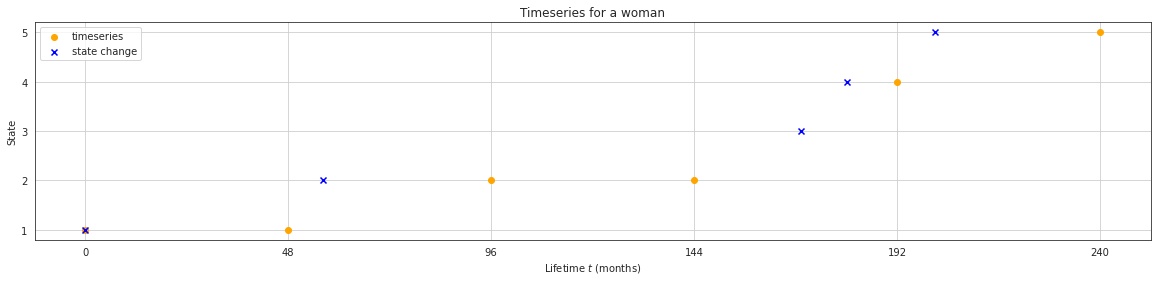

In [ ]:
example_trajectory = np.array([[0, 0], [56.2, 1], [169.2, 2], [180.1, 3], [201.1, 4]])
example_timeserie = extract_timeseries(example_trajectory, time_between)
plot_timeseries(example_trajectory, example_timeserie, time_between)

This example figure above illustrates 
* The case when nothing changed between screenings at the doctor's office every 4 years. Here, the state 2 is observed a second time between 96 and 144 months.
* The case when multiple changes of state occured during the same 4 years window. In that case, only the last one is observed and the state before that are unreported. Here, the state 3 is unreported between 144 and 192 months.

## Task 13

In this task, the transition rate matrix $Q$ is viewed as unknown, and the transition matrix $Q$ will be estimated using the Monte Carlo Expectation Maximization algorithm. The set of $1000$ timeseries generated in task 12 will be used to do the estimation.

In [ ]:
def jump_state(Q, i):
    ### starting in state i, compute probabilities of moving to state 0...k
    probs = [-Q[i][k] / Q[i][i] for k in range(Q.shape[1])]

    # Q[k,k] = Q[k][]
    ### -Q[k][k]/Q[k][k] = -1
    ### can't move to same state so set probability to 0 where its -1
    probs = [0.0 if x < 0.0 else x for x in probs]

    ### pick a new state based on probabilities defined before
    i_star = np.random.choice([0, 1, 2, 3, 4], p=probs)

    return i_star

The function below implement the first step of the algorithm, $i.e.$ sampling a trajectory for each woman that matches their timeserie.

Two tricks were implemented to improve the performance of the rejection sampling. 
* First, if an interval, $i.e.$ a window of time of 48 months, is rejected, we do not reject the whole trajectory (and have to restart at t=0). But we rather restart only the rejected window of time. Indeed, the previous intervals already matched with the timeserie, so why throw them away? 
* Secondly, if the timeserie shows no change of state during an interval, there is no need to simulate that interval.

In [ ]:
def simulate_complete_matching_trajectories(Q, timeseries):
    trajectories = {}
    # For each woman
    for i in range(timeseries.shape[1]):

        # Observed time serie for 1 woman
        Y = timeseries[:, i]

        traj = [[0.0, 0]]
        # For each interval between observations
        for j, y_init in enumerate(Y[:-1]):
            y_goal = Y[j + 1]
            # No need to simulate if nothing happened
            if y_init == y_goal:
                continue

            # SIMULATE ONE TRAJECTORY WITH CHANGE OF STATE FOR 48 MONTHS:
            accepted = False
            while not accepted:
                y_init = Y[j]
                jumps = []
                t = 0
                while t < 48 and y_init != 4:
                    t_jump = np.random.exponential(
                        scale=1 / -Q[int(y_init)][int(y_init)]
                    )
                    if t_jump < 48 - t:
                        y_init = jump_state(Q, int(y_init))
                        jumps += [[48 * j + t_jump, y_init]]

                    t += t_jump

                # If no change of state, try again
                if len(jumps) == 0:
                    continue
                # Else, check state after 48 months
                else:
                    y_sim = jumps[-1][1]  # Check-up

                # Rejection sampling
                if y_goal == y_sim:  # Accept if it matches
                    accepted = True
                    traj += jumps

        trajectories[i] = np.array(traj)

    return trajectories

In [ ]:
def summarize_trajectories(trajectories):
    N = np.zeros((5, 5))
    S = np.zeros(5)

    for k, traj in trajectories.items():
        for i in range(traj.shape[0] - 1):

            # N: total number of jumps
            N[int(traj[i, 1]), int(traj[i + 1, 1])] += 1

            # S: total sojourn time
            S[int(traj[i, 1])] += abs(traj[i + 1, 0] - traj[i, 0])

    return N, S

In [ ]:
def update_Q(N, S):
    nstates = N.shape[0]
    Q = np.ones((nstates, nstates))
    for row in range(Q.shape[0]):
        Q[row, :] = [
            N[row, col] / S[row] if S[row] != 0 else 0 for col in range(Q.shape[1])
        ]

    ### update diagonals
    updated_diagonals = [
        -(np.sum(Q[row, :]) - Q[row, row]) for row in range(Q.shape[0])
    ]
    np.fill_diagonal(Q, updated_diagonals)

    return Q

In [ ]:
def MC_Expectation_Maximization_algo(Q_0, timeseries, N_iter=10, epsilon=10e-3):

    Qapprox = Q_0
    convergence = False
    for k in range(N_iter):
        print("Iteration", k + 1)

        # Simulate entire trace with matching trajectories - timeseries using Qapprox
        trajectories = simulate_complete_matching_trajectories(
            Qapprox, timeseries[:, 1:]
        )

        # Compute N and S from entire trace
        N, S = summarize_trajectories(trajectories)

        # Define Q with updated qi,j
        Q = update_Q(N, S)

        if np.linalg.norm(Qapprox - Q, ord=np.inf) < epsilon:
            Qapprox = Q
            convergence = True
            print(
                "Algorithm reached convergence criterion after {} iteration(s)".format(
                    k + 1
                )
            )
            break

        Qapprox = Q

    if not convergence:
        print("Warning: the algorithm has not reached the convergence criterion.")

    return Qapprox

In [ ]:
def get_initial_Q(n_states):
    Q_0 = (
        np.ones((n_states, n_states)) * 0.01
    )  # 0.1 jumps to large, 0.00001 jumps too short

    updated_diagonals = [
        -(np.sum(Q_0[row, :]) - Q_0[row, row]) for row in range(Q_0.shape[0])
    ]
    np.fill_diagonal(Q_0, updated_diagonals)

    return Q_0

In [ ]:
Q_0 = get_initial_Q(Q.shape[0])
Q_approx = MC_Expectation_Maximization_algo(Q_0, timeseries, N_iter=200, epsilon=10e-4)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Algorithm reached convergence criterion after 4 iteration(s)


In [ ]:
print("Original Q")
print(Q)
print("Initial guess Q0")
print(Q_0)
print("Approximated Q (rounded)")
print(np.round(Q_approx, decimals=4))

Original Q
[[-0.0085  0.005   0.0025  0.      0.001 ]
 [ 0.     -0.014   0.005   0.004   0.005 ]
 [ 0.      0.     -0.008   0.003   0.005 ]
 [ 0.      0.      0.     -0.009   0.009 ]
 [ 0.      0.      0.      0.      0.    ]]
Initial guess Q0
[[-0.04  0.01  0.01  0.01  0.01]
 [ 0.01 -0.04  0.01  0.01  0.01]
 [ 0.01  0.01 -0.04  0.01  0.01]
 [ 0.01  0.01  0.01 -0.04  0.01]
 [ 0.01  0.01  0.01  0.01 -0.04]]
Approximated Q (rounded)
[[-0.0084  0.0043  0.0028  0.0005  0.0009]
 [ 0.     -0.0125  0.0046  0.003   0.0048]
 [ 0.      0.0001 -0.0082  0.0031  0.0051]
 [ 0.      0.      0.0002 -0.0097  0.0096]
 [ 0.      0.      0.      0.     -0.    ]]


We see that the approximated $Q^{*}$ is quite close to the original $Q$. Thus we have been able to retrieve the original $Q$ matrix using only partial simulation information and an initial guess $Q_0$. The algorithm is very fast thanks to tricks made to improve the performance of the rejection sampling.

Notice how the lower triangle part of the approximated matrix and the last row has been correctly set to 0 despite the inital guess having values there. This means that the algorithm correctly simulated trajectories matching with the observed timeseries. Indeed, in those timeseries, it impossible to see those types of transitions, thus $N_i,j$ is 0.

Moreover, we observed that the choice of $Q_0$ has an effect on the algorithm. We decided to have for inital guess a matrix whose non-diagonal elements are all the same (and the diagonal is computed to have the property that a row sums to 0).

Initializing $Q_0$ with too large values ($10^{-1}$), or too small ($10^{-5}$), leads to a very long first iteration. Indeed, in those cases, the rejection sampling nearly always reject trajectories because it simulates either too many jumps or nearly never jump to another state in a window of time of 48 months. Indeed, the time a jump occurs is defined by the sojourn time directly computed from the element of the matrix $Q$.